In [1]:
# Niranjan J 19MIA1003
# Roshan Srinivaas S 19MIA1001

In [61]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

<a id='1'></a><br>
# Load and Check Data

In [62]:
all_0 = "../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all"
all_1 = "../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/all"
all_2 = "../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/all"

hem_0 = "../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/hem"
hem_1 = "../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/hem"
hem_2 = "../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/hem"

In [63]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder) 
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)
    
    return image_paths

In [64]:
img_data = []

for i in [all_0,all_1,all_2,hem_0,hem_1,hem_2]:
    paths = get_path_image(i)
    img_data.extend(paths)
print(len(img_data))

10661


In [65]:
data = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

data = pd.DataFrame(data) 

In [66]:
data["labels"][0:7272] = 1 # ALL
data["labels"][7272:10661] = 0 # HEM

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [67]:
data["labels"] = data["labels"].astype("int64")

<a id='2'></a><br>
# Crop Black Edges In Image

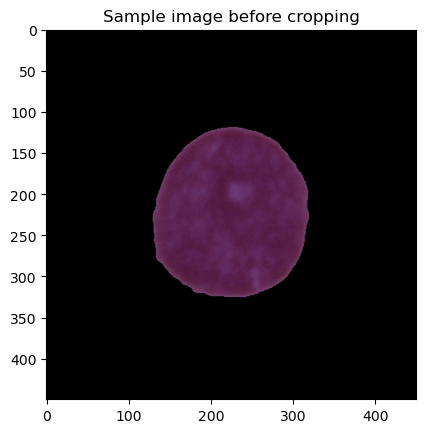

In [68]:
image = cv.imread(data["img_data"][1000])
plt.imshow(image)
plt.title("Sample image before cropping")
plt.show()

In [69]:
img_list = []
for i in range(len(img_data)):
    image = cv.imread(data["img_data"][i])
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255] 
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))
    crop_img = image[mnx:mxx,mny:mxy,:]
    crop_img_r = cv.resize(crop_img, (224,224))
    img_list.append(crop_img_r)

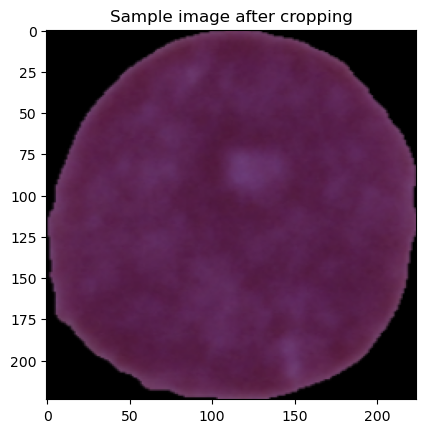

In [70]:
plt.imshow(img_list[1000])
plt.title("Sample image after cropping")
plt.show()

<a id='3'></a><br>
# Feature Extraction with ResNet50

In [71]:
from tensorflow.keras.applications import ResNet50, ResNet101
from keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input

In [72]:
def feature_extract(model):
    if model == "VGG19": model = VGG19(weights='imagenet',include_top=False, pooling="avg")
    elif model == "ResNet50": model = ResNet50(weights='imagenet',include_top=False,pooling="avg")
    elif model == "ResNet101": model = ResNet101(weights='imagenet',include_top=False,pooling="avg")
    return model

In [73]:
model = feature_extract("ResNet50") 

In [74]:
features_list = []
for i in range(len(img_list)):
            
    image = img_list[i].reshape(-1, 224, 224, 3)
    image = preprocess_input(image)
    features = model.predict(image).reshape(2048, )
    features_list.append(features)

1/1 [==============================] - 0s 127ms/step


In [75]:
features = model.predict(image).reshape(2048, )
features_list.append(features)

In [76]:
features_df = pd.DataFrame(features_list)

In [77]:
features_df["labels"] = data["labels"]

In [78]:
x = features_df.drop(['labels'], axis = 1)
y = features_df.loc[:,"labels"].values

In [79]:
x

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,3.888965,0.003357,0.000000,0.080566,0.002496,0.003217,0.178870,0.054217,0.015593,0.044378,...,1.161147,0.046141,0.090094,0.396494,0.005847,0.000000,0.605872,0.689851,0.192494,1.315786
1,6.105568,0.000000,0.008155,0.063793,0.005606,0.047762,0.079004,0.000000,0.002628,0.012909,...,0.067440,0.000000,0.000000,0.291204,0.000000,0.000000,0.194592,0.897486,0.181279,0.888027
2,4.191666,0.000000,0.000000,0.073727,0.007410,0.040819,0.126976,0.026118,0.000000,0.000000,...,0.646453,0.000000,0.218996,0.082670,0.000000,0.000000,0.033167,0.255844,0.011669,1.841871
3,4.969837,0.190751,0.000000,0.060903,0.012210,0.034155,0.038725,0.035803,0.183820,0.000000,...,0.090973,0.018727,0.066534,0.355468,0.086318,0.053395,0.031325,0.539635,0.013693,1.445034
4,7.409759,0.000000,0.000000,0.223266,0.000000,0.013826,0.060581,0.000000,0.044893,0.025707,...,0.179018,0.005104,0.000000,0.408164,0.000000,0.000000,0.100929,0.117949,0.972514,0.484715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10656,4.650623,0.000000,0.000000,0.003782,0.000000,0.000000,0.079633,0.035964,0.052119,0.277229,...,1.089402,0.014226,0.000000,1.019124,0.584857,0.000000,0.643598,0.648637,0.098623,0.295180
10657,5.075249,0.000000,0.000000,0.073403,0.000000,0.050068,0.109488,0.000000,0.127485,0.027882,...,0.697676,0.000000,0.084635,0.057695,0.176103,0.000000,0.666509,0.455349,1.335689,0.615851
10658,5.491919,0.000000,0.000000,0.062658,0.087209,0.227873,0.310514,0.037401,0.000000,0.043395,...,0.154101,0.003430,0.000000,0.094444,0.133244,0.000000,0.083235,0.834814,0.120172,2.136771
10659,4.076108,0.017551,0.000000,0.118688,0.000000,0.000000,0.148364,0.000000,0.000000,0.000000,...,0.407699,0.026058,0.270066,0.208164,0.037543,0.000000,0.560540,0.330985,0.199827,1.003238


In [80]:
print(f"Number of features before feature selection: {x.shape[1]}")

Number of features before feature selection: 2048


In [81]:
y

array([1, 1, 1, ..., 0, 0, 0])

<a id='4'></a><br>
# Data Scaling

In [82]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x)
x_ = scaler.transform(x)

In [83]:
x_ = pd.DataFrame(x_)

<a id='5'></a><br>
# Feature Selection Methods

<a id='6'></a><br>
## ANOVA 

In [84]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def anova_fs():
    
    selector = SelectKBest(f_classif, k=500) # k is number of features
    selector.fit(x_, y)

    cols = selector.get_support(indices=True)
    anova_x = x_[cols]
    return anova_x

<a id='7'></a><br>
## Recursive Feature Elimination (RFE)

In [85]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

def RFE_fs():
    rfe_selector = RFE(estimator=RandomForestClassifier())
    rfe_selector.fit(x_, y)
    
    rfe_support = rfe_selector.get_support()
    rfe_feature = x_.loc[:,rfe_support].columns.tolist()
    
    rfe_x = x_[rfe_feature]
    return rfe_x

<a id='8'></a><br>
## Random Forest

In [86]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

def rf_fs():
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=5), threshold='1.25*median')
    embeded_rf_selector.fit(x, y)
    
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = x.loc[:,embeded_rf_support].columns.tolist()
    
    rf_x = x[embeded_rf_feature]
    return rf_x

In [87]:
fs_x = rf_fs() 

In [88]:
print(f"Number of features after feature selection: {fs_x.shape[1]}")

Number of features after feature selection: 590


<a id='9'></a><br>
# Train Test Split

In [89]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(fs_x, y, test_size = 0.2, random_state = 42)

<a id='10'></a><br>
# Classification with ML Algorithms

In [90]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import GridSearchCV

<a id='11'></a><br>
## kNN

In [91]:
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []

for i, k in enumerate(neig):

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    prediction_ = knn.predict(x_test)
    train_accuracy.append(knn.score(x_train, y_train))
    test_accuracy.append(knn.score(x_test, y_test))
    
print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

Best accuracy is 0.8326300984528833 with K = 15


In [92]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(x_train,y_train)
predicted = knn.predict(x_test)
score = knn.score(x_test, y_test)
knn_score_ = np.mean(score)

print('Accuracy : %.3f' % (knn_score_))

Accuracy : 0.832


In [93]:
p=precision_score(y_test, predicted) 
print('Precision : %.3f' % (p))

r=recall_score(y_test, predicted) 
print('Recall : %.3f' % (r))

f1=f1_score(y_test, predicted) 
print('F1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted') 
print('Weighted f1-score: %.3f' % (f1_w))

Precision : 0.838
Recall : 0.935
F1-score: 0.884
Weighted f1-score: 0.825


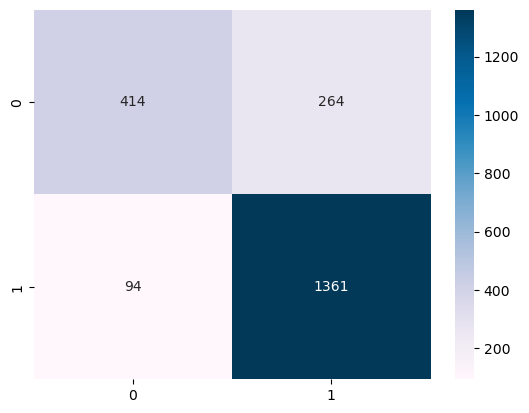

In [94]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

<a id='12'></a><br>
## SVM

In [95]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']}
 
SVM_grid = GridSearchCV(svm.SVC(), param_grid_svm, cv=5)
SVM_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']})

In [96]:
print(SVM_grid.best_params_)
 
print(SVM_grid.best_estimator_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, gamma=0.01)


In [97]:
svm_clf = svm.SVC(C=100, gamma=0.01, kernel='rbf')
svm_clf.fit(x_train,y_train)
predicted = svm_clf.predict(x_test)
score = svm_clf.score(x_test, y_test)
svm_score_ = np.mean(score)

print('Accuracy : %.3f' % (svm_score_))

Accuracy : 0.899


In [98]:
p=precision_score(y_test, predicted) 
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted) 
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted) 
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted') 
print('weighted f1-score: %.3f' % (f1_w))

precision : 0.901
recall : 0.957
f1-score: 0.928
weighted f1-score: 0.897


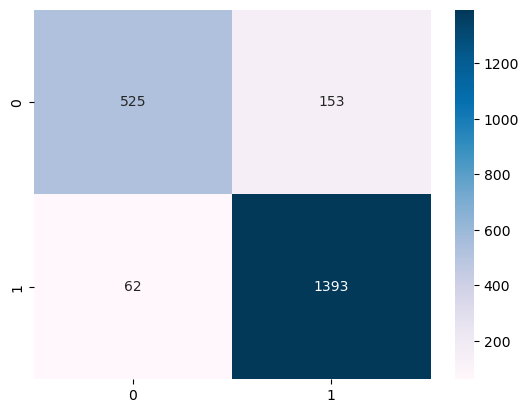

In [99]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

<a id='13'></a><br>
## Random Forest

In [100]:
param_grid_rf = { 
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8]}

RF_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv= 5)
RF_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [101]:
print(RF_grid.best_params_)

{'max_depth': 8, 'n_estimators': 500}


In [102]:
r_forest = RandomForestClassifier(500,max_depth=8, random_state=5)
r_forest.fit(x_train,y_train)
predicted = r_forest.predict(x_test)
score = r_forest.score(x_test, y_test)
rf_score_ = np.mean(score)

print('Accuracy : %.3f' % (rf_score_))

Accuracy : 0.826


In [103]:
p=precision_score(y_test, predicted) 
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted) 
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted) 
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted') 
print('weighted f1-score: %.3f' % (f1_w))

precision : 0.821
recall : 0.952
f1-score: 0.882
weighted f1-score: 0.815


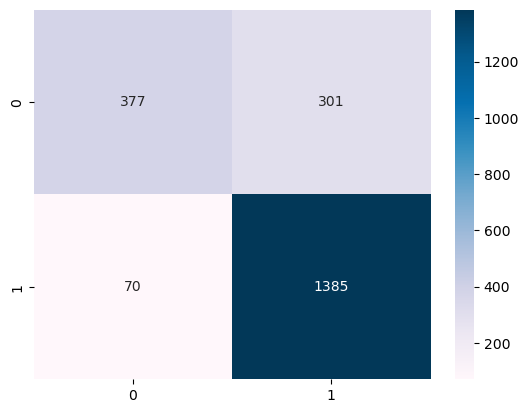

In [104]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

<a id='14'></a><br>
## Naive Bayes

In [105]:
nb_model = GaussianNB()
nb_model.fit(x_train,y_train)
predicted = nb_model.predict(x_test)
score = nb_model.score(x_test, y_test)
nb_score_ = np.mean(score)

print('Accuracy : %.3f' % (nb_score_))

Accuracy : 0.765


In [106]:
p=precision_score(y_test, predicted) 
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted) 
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted) 
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted') 
print('weighted f1-score: %.3f' % (f1_w))

precision : 0.849
recall : 0.797
f1-score: 0.822
weighted f1-score: 0.768


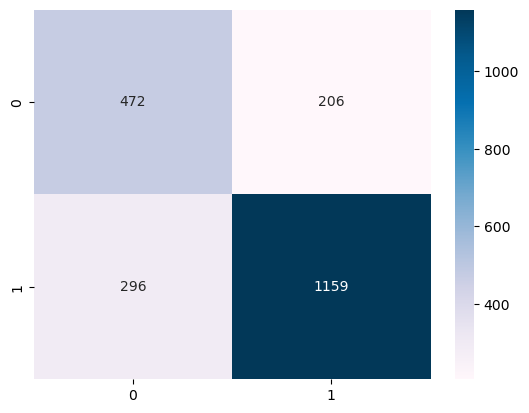

In [107]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()